In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import transformations as t
from mpl_toolkits.mplot3d import Axes3D
import os

tf.logging.set_verbosity(tf.logging.INFO)

def show_cv2(img):
    # swap b and r channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()

def plot_histogram(img):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
def add_grayscale_noise(img, std_dev):
    noise = np.expand_dims(np.random.normal(0, std_dev, size=img.shape[:2]).astype(np.int8), axis=2)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img

def add_colored_noise(img, std_dev):
    noise = np.random.normal(0, std_dev, size=img.shape).astype(np.int8)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def listfiles(path):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn]
tag_urls = listfiles("./tags")
scene_urls = listfiles("./places")

print(tag_urls[0], scene_urls[0])

./tags/tag36_11_00142.png ./places/Places365_val_00013979.jpg


In [3]:
# Populate some camera intrinsic settings
# And other constants
# To do: capitolize these variables names idk how to find and replace in this notebook

camera_intrinsics = [1.1998640834468974e+03, 0, 640.0 / 2, 0, 1.1998640834468974e+03, 480.0 / 2, 0, 0, 1]
camera_intrinsics = np.array(camera_intrinsics).reshape([3, 3])

fx = camera_intrinsics[0,0]
fy = camera_intrinsics[1,1]
cx = camera_intrinsics[0,2]
cy = camera_intrinsics[1,2]

tag_size = 0.01

print(camera_intrinsics)

[[1.19986408e+03 0.00000000e+00 3.20000000e+02]
 [0.00000000e+00 1.19986408e+03 2.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [9]:
def gen_sample(noise_background=False, plot=False):
    if noise_background:
        img_scene = np.random.randint(0, 255, size=(480, 640, 3)).astype(np.uint8)
    else:
        img_scene = cv2.resize(cv2.imread(np.random.choice(scene_urls)), (640, 480), interpolation=cv2.INTER_AREA)

    img_tag = cv2.resize(cv2.imread(np.random.choice(tag_urls)), (200, 200), interpolation=cv2.INTER_NEAREST)

    world_corners = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]]) * tag_size / 2.0
    pixel_corners = np.array([[0, 0], [1, 0], [0, 1], [1, 1]]) * np.array(img_tag.shape)[:2]

    # Add a Z component and homogeneous coordinate
    corners_3d = np.hstack((world_corners, np.array([[0, 1]] * 4)))
    
    
    done = False
    attempts = 0
    while not done:
        # Apply a random rotation to our corners
        angle_lim = np.pi / 2.5
        x_rot = np.random.uniform(-angle_lim, angle_lim)
        rotation_matrix = t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [1, 0, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [0, 1, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-np.pi, np.pi), [0, 0, 1])
        corners_3d_rotated = (rotation_matrix @ corners_3d.T).T

        # Translate our corners to a random 3D point within our camera view
        z = np.random.triangular(0.05, 0.05, 0.2)
        x = np.random.uniform(-1, 1) * z / fx * cx
        y = np.random.uniform(-1, 1) * z / fy * cy
        translation = np.array([x, y, z])
        translation_matrix = t.translation_matrix(translation)
        corners_3d_transformed = (translation_matrix @ corners_3d_rotated.T).T

        # Project into 2D image space
        projected_transformed = camera_intrinsics @ corners_3d_transformed.T[:3]
        projected_transformed /= projected_transformed[2]

        projected_transformed = np.vstack((projected_transformed[0], projected_transformed[1]))
        # print(projected_transformed)

        done = True
        attempts += 1
        for (x, y) in projected_transformed.T:
            # Reject views that have tag corners chopped off
            if x < 0 or y < 0 or x > cx * 2 or y > cy * 2:
                done = False

    # print(attempts, "attempt(s)")

    # Compute a homography
    H = cv2.findHomography(pixel_corners, projected_transformed.T)[0]

    # Random lighting condition
    dynamic_range = np.random.uniform(0.9, 1.0)
    img_tag_lighting = img_tag * dynamic_range
    img_tag_lighting += (1.0 - dynamic_range) * np.random.uniform(0, 255)
    img_tag_lighting = img_tag_lighting.astype(np.uint8)
    
    # Some noise
    img_tag_filtered = cv2.GaussianBlur(img_tag_lighting, (9, 9), 0)
    img_tag_filtered = add_colored_noise(img_tag_filtered, 4)
    img_tag_filtered = add_grayscale_noise(img_tag_filtered, 10)
    
    # Overlay warped image
    img_scene_with_tag = np.array(img_scene)
    cv2.warpPerspective(img_tag_filtered, H, dsize=img_scene.shape[:2][::-1], dst=img_scene_with_tag, borderMode=cv2.BORDER_TRANSPARENT)
    img_scene_with_tag = cv2.GaussianBlur(img_scene_with_tag, (3, 3), 0)
    img_scene = cv2.GaussianBlur(img_scene, (3, 3), 0)

    # Bias our tag's color towards the image average color
    img_tag_filtered = (img_tag_filtered * 49.0 / 50.0 + (np.mean(img_scene,axis=(0,1)) / 50.0).astype(np.int16)).astype(np.uint8)

    # Plot?
    if plot:
        show_cv2(img_tag_filtered)
        
        # Visualize in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xs = corners_3d.T[0]
        ys = corners_3d.T[1]
        zs = corners_3d.T[2]
        ax.scatter(xs, ys, zs)

        xs = corners_3d_transformed.T[0]
        ys = corners_3d_transformed.T[1]
        zs = corners_3d_transformed.T[2]
        ax.scatter(xs, ys, zs)

        # Visualize in 3D
        plt.figure()
        plt.ylim(0, cy * 2)
        plt.xlim(0, cx * 2)

        #xs = projected_orig[0]
        #ys = projected_orig[1]
        #plt.scatter(xs, ys)
        xs = projected_transformed[0]
        ys = projected_transformed[1]
        plt.plot(xs, ys)

        plt.show()
        
        # Visualize the scene + histograms
        plot_histogram(img_scene)
        show_cv2(img_scene)

        plot_histogram(img_scene_with_tag)
        show_cv2(img_scene_with_tag)

    return img_scene, img_scene_with_tag, corners_3d_transformed

# gen_sample(False, True)
# pass

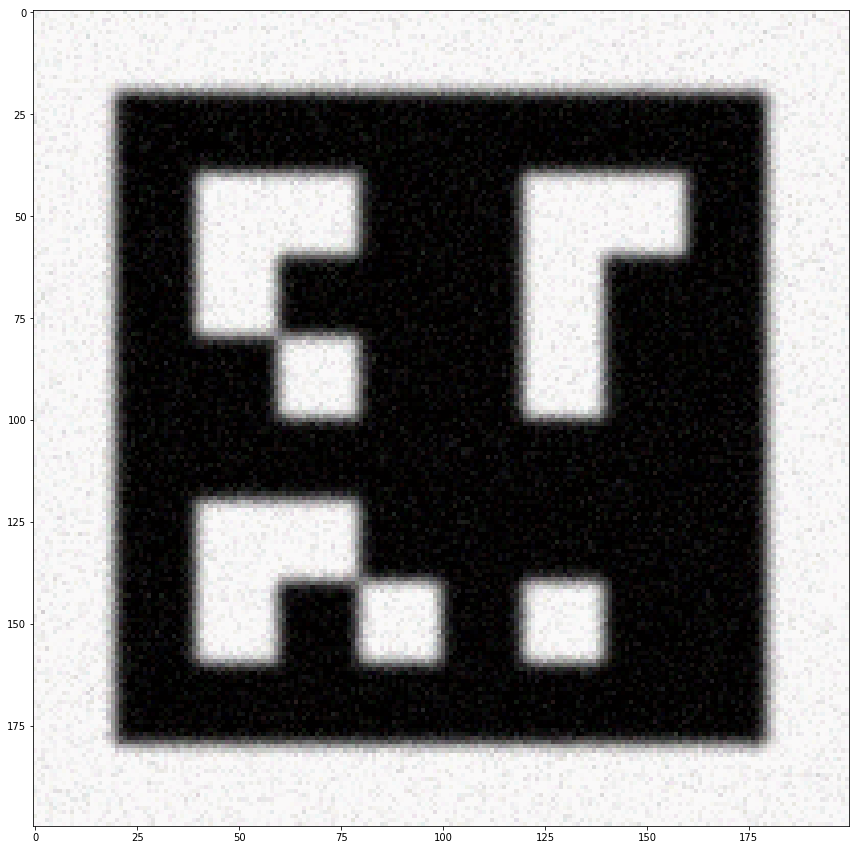

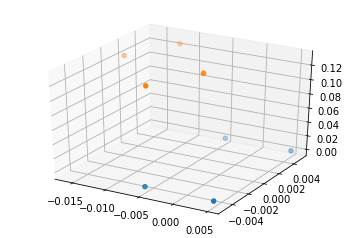

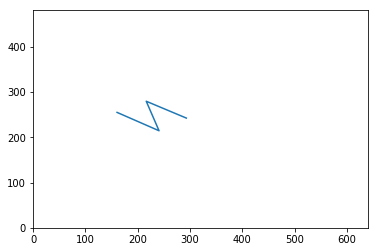

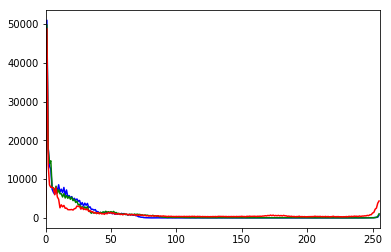

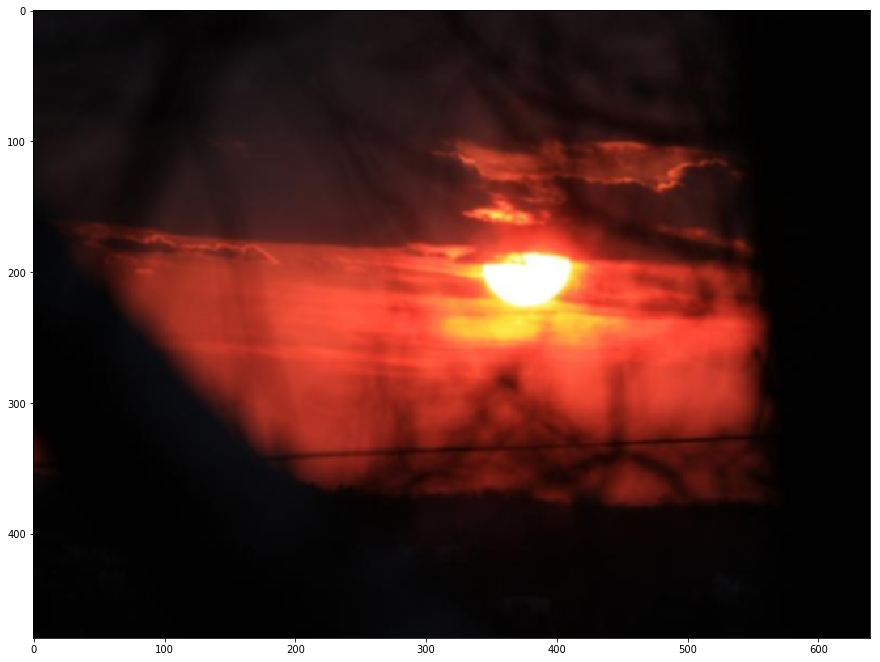

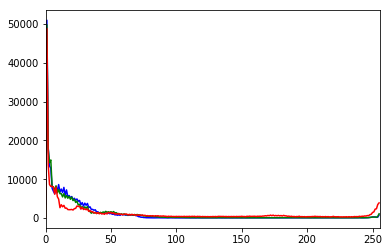

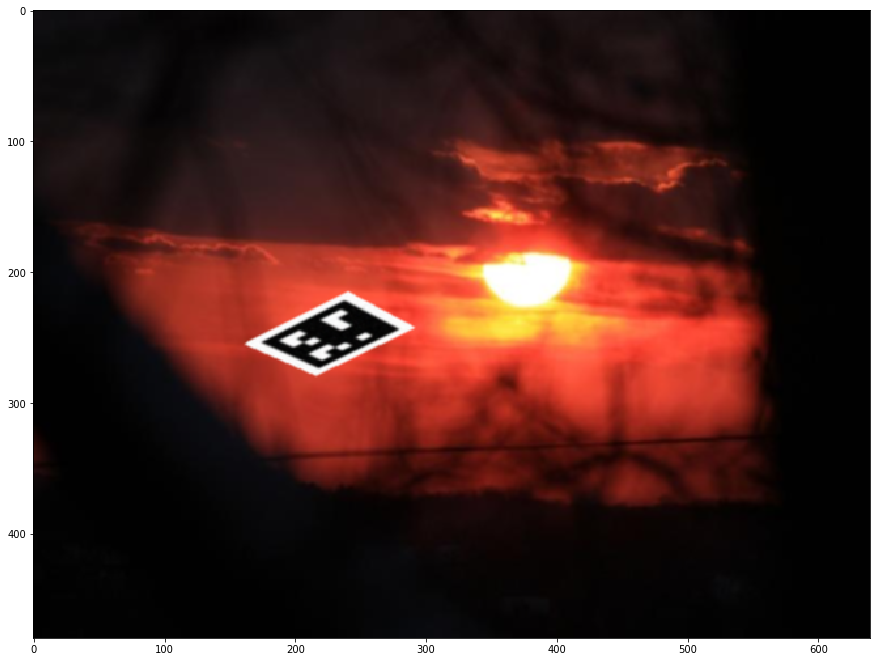

[[-1.61723848e-02  1.49522836e-03  1.21703604e-01  1.00000000e+00]
 [-7.79105150e-03 -2.53399240e-03  1.18026834e-01  1.00000000e+00]
 [-1.12276853e-02  4.26173446e-03  1.29943530e-01  1.00000000e+00]
 [-2.84635207e-03  2.32513702e-04  1.26266761e-01  1.00000000e+00]]


In [10]:
# Test for generating training sample

gen_sample(False, True)
pass

In [6]:
global global_scene

# Helper for generating training/validation batches

def gen_samples(n, noise_scene=False, plot=False, include_neg=False):
    images = []
    labels = []
    for _ in range(n):
        neg, pos, transform = gen_sample(noise_scene, plot)
        
        global global_scene
        global_scene = pos

        neg = neg.astype(np.float32)
        pos = pos.astype(np.float32)
        neg /= 255.0
        neg -= 0.5
        pos /= 255.0
        pos -= 0.5

        if include_neg:
            images.append(neg)
            labels.append(0)
            
        images.append(pos)
        labels.append(transform)
        
    return np.asarray(images), np.asarray(labels).astype(np.float32)

In [7]:
def cnn_model_fn(features, labels, mode):

    """Model function for CNN."""
    # Input Layer
    
    #######################################################33
    # TODO: fill in size
    size = [480, 640]
    
    input_layer = tf.image.resize_images(
                            features["x"],
                            size,
                            method=tf.image.ResizeMethod.BILINEAR,
                            align_corners=False)

    ### TODO: make these stride size smaller when we have more than 2 hours to train this model
    print("features", features["x"].shape)
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.leaky_relu)
    
    conv1_1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.tanh)
    
    print("conv1", tf.concat([conv1, conv1_1], axis=1).shape)
#     pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 5], strides=4)
    pool1 = tf.layers.max_pooling2d(inputs=tf.concat([conv1, conv1_1], axis=1), pool_size=[4, 5], strides=4)

    print("pool1", pool1.shape)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.leaky_relu)
    
    print("conv2", conv2.shape)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[9, 4], strides=4)
    print("pool2", pool2.shape)
    
    
    pool2 = tf.layers.dropout(inputs=pool2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=16,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.leaky_relu)
    print("conv3", conv3.shape)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[7, 5], strides=[13, 9])
    print("pool3", pool3.shape)
    
    conv4 = tf.layers.conv2d(
        inputs=pool3,
        filters=1,
        kernel_size=[8, 6],
        padding="same",
        activation=tf.nn.sigmoid)
    print("conv4", conv4.shape)
    
    dropout = tf.layers.dropout(inputs=conv4, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)
    print("dropout", dropout.shape)
    
    
    prob = tf.squeeze(dropout, -1, name="prob_tensor")
    print("probabilities", prob.shape)
    
    labels = tf.convert_to_tensor(labels, dtype=tf.float32, name="label_tensor")
    labels = tf.add(labels, tf.constant(0.0), name="label_tensor")
    print("label", labels.shape)
    
    predictions = {
      "predictions": tf.round(prob),
      "probabilities": prob
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return prob

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.nn.l2_loss(labels - prob, name="loss")
    print(loss)

    # Add a margin to the lossf
    # loss = tf.maximum(tf.constant(0.0), loss - 0.0004)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    
    # Saliency
    
    accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["predictions"], name="accuracy")
    
    saliency_grad = tf.gradients(prob, input_layer, name="saliency_grad")
    saliency_map = tf.squeeze(tf.reduce_max(tf.abs(saliency_grad), axis=4), name="saliency_map")

    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [8]:
print("Building estimator...", flush=True)
# Create the Estimator
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./transform_model")

def train():
    #######################################################
    # TODO NEED TO FIX THE ENTIRE FUNCTION

    # Set up logging for predictions
    tensors_to_log = {"loss": "loss", "prob": "prob_tensor", "labels": "label_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=100)

    print("Training model...", flush=True)
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)

    classifier.train(
      input_fn=train_input_fn,
      steps=4)
# train()

def eval():
    print("Evaluating model...", flush=True)
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    saliency_hook = SaliencyHook()
    eval_results = classifier.evaluate(input_fn=eval_input_fn, hooks=[saliency_hook])
    print(eval_results)

    
    
for i in range(250):
    train_data, train_labels = gen_samples(50, False)
    train()


Building estimator...


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_id': 0, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c00576668>, '_service': None, '_save_checkpoints_steps': None, '_task_type': 'worker', '_evaluation_master': '', '_keep_checkpoint_max': 5, '_model_dir': './transform_model', '_num_ps_replicas': 0, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_master': '', '_tf_random_seed': None, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600}


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 83.89602, step = 0
INFO:tensorflow:Saving checkpoints for 4 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.759705.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-4
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 32.503765, step = 4
INFO:tensorflow:Saving checkpoints for 8 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 39.872986.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-8
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 33.610004, step = 8
INFO:tensorflow:Saving checkpoints for 12 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.756222.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-12
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 13 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.388685, step = 12
INFO:tensorflow:Saving checkpoints for 16 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.704268.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-16
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)


KeyboardInterrupt: 